In [1]:
import os
import numpy as np 
import pandas as pd
from scipy import stats, signal, io
import mne
from mne import create_info, EpochsArray
from mne.time_frequency import tfr_morlet
from bids import BIDSLayout
import mne_bids
import scipy
#import settings
import json
#from coordinates_io import BIDS_coord
from sklearn import linear_model, metrics
import multiprocessing
from sklearn.model_selection import cross_val_score
from sklearn import ensemble, model_selection
from matplotlib import pyplot as plt
import matplotlib 

In [2]:
out_path = '/home/icn/Documents/raw_out/RF_32_4/'
BIDS_path = '/home/icn/Documents/BIDS/'

In [3]:
subject_exclude = ['002', '003', '011', '012', '015']
subject_tf_usage = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014', '016']
#002 - DBS4011 - no locaization possible
#003 - DBS4020 - LEFT due to signal quality
#011 - DBS4037 - STN was not recorded
#012 - DBS4030 - GPi not STN 
#015 - DBS4065 - LEFT due to signal quality

In [4]:
subject_id = []
for patient_test in range(17):
    if patient_test < 10:
        subject_id.append(str('00') + str(patient_test))
    else:
        subject_id.append(str('0') + str(patient_test))


### TF-PLOTS

In [5]:
# calculate average of best TF Plots: ECOG/STN Con/Ips
# for this: 1. get the best channel
# given this channel: load the BIDS file and load the concatenation for that channel
# important: I have already done that! check in VS project 
# then estimate morlet transform 
# this needs to be split for Con and Ips

In [6]:
layout = BIDSLayout(BIDS_path)
tsv_files = layout.get(extension='tsv', return_type='filename')
vhdr_files = layout.get(extension='vhdr', return_type='filename')

In [7]:
def read_BIDS_file(vhdr_file):
    """
    Read one run file from BIDS standard
    :param vhdr_file: 
    :return: raw dataset array, channel name array
    """
    bv_file = mne_bids.read.io.brainvision.read_raw_brainvision(vhdr_file)
    bv_raw = bv_file.get_data()
    return bv_raw, bv_file.ch_names

In [8]:
def get_movement_idx(ch, mov_channels, Con=True):
    """returns index of mov_channels given boolean Con and ch
    
    Arguments:
        ch {string} -- given channel string
        mov_channels {list} -- string list of used movement channels including LEFT or RIGHT
    
    Keyword Arguments:
        Con {bool} -- laterality (default: {True})
    
    Returns:
        int -- index of mov_channel of the lateral channel
    """
    mov_idx = 0
    if len(mov_channels) > 1:    
        if Con is True:
            if ("RIGHT" in ch and "LEFT" in mov_channels[0]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "LEFT" in mov_channels[1]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[1]):
                mov_idx = 1
        else:
            if ("RIGHT" in ch and "RIGHT" in mov_channels[0]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "RIGHT" in mov_channels[1]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[1]):
                mov_idx = 1
    return mov_idx


In [9]:
def get_best(dict_ch, Con=True, ECOG=True, get_weights=True, get_data=False, measure='R2'):
    """
    return best channel name, best channel performance, and respective weights
    """
    channels = list(dict_ch.keys())
    if ECOG is True:
        list_ch = [ch for ch in channels if 'ECOG' in ch]
        num_ch = len(list_ch)
    else:
        list_ch = [ch for ch in channels if 'STN' in ch]
        num_ch = len(list_ch)

    if num_ch == 0:
        raise ValueError

    
    acc_ = np.zeros(num_ch)
    mov_idx_ = np.zeros(num_ch)
    counter_ch = 0

    for ch_idx, ch  in enumerate(channels):
        if ECOG is True and 'STN' in ch:
            continue
        elif ECOG is False and 'ECOG' in ch:
            continue
        mov_channels = dict_ch[channels[ch_idx]]["mov_ch"]
        mov_idx = get_movement_idx(channels[ch_idx], mov_channels, Con)
        acc_[counter_ch] = dict_ch[channels[ch_idx]]['res_'+mov_channels[mov_idx]][measure]
        mov_idx_[counter_ch] = mov_idx
        counter_ch += 1

    best_ch_idx = np.argmax(acc_)
    mov_idx_best = int(mov_idx_[best_ch_idx])
    best_ch = list_ch[best_ch_idx]; best_acc = np.max(acc_)
    if get_weights is False:
        if get_data is False:
            return best_ch, best_acc
        else:
            return best_ch, best_acc, np.array(dict_ch[best_ch]['data']), \
                                       np.array(dict_ch[best_ch]['true_movements'])[mov_idx_best,:]
    best_weights = dict_ch[channels[best_ch_idx]]['res_'+mov_channels[mov_idx_best]]['weight_'+mov_channels[mov_idx_best]]
    return best_ch, best_acc, best_weights

In [10]:
def calc_epochs(bv_raw, y_tr, info, threshold, epoch_lim):
     
    ind_mov = np.where(np.diff(np.array(y_tr>threshold)*1) == 1)[0]
    low_limit = ind_mov>epoch_lim
    up_limit = ind_mov < y_tr.shape[0]-epoch_lim
    ind_mov = ind_mov[low_limit & up_limit]
    bv_epoch = np.zeros([ind_mov.shape[0], int(epoch_lim*2)])
    y_arr = np.zeros([ind_mov.shape[0],int(epoch_lim*2)])
    n_epochs = bv_epoch.shape[0]
    events = np.empty((n_epochs, 3), dtype=int)


    event_id = dict(mov_present=1)

    for idx, i in enumerate(ind_mov):
        bv_epoch[idx,:] = bv_raw[i-epoch_lim:i+epoch_lim]
        y_arr[idx,:] = y_tr[i-epoch_lim:i+epoch_lim]
        events[idx,:] = i, 0, event_id["mov_present"]
    print(bv_epoch.shape)
    bv_epoch = np.expand_dims(bv_epoch, axis=1)
    print(bv_epoch.shape)
    epochs = EpochsArray(data=bv_epoch, info=info, events=events, event_id=event_id)
    return epochs

In [11]:
def load_concat_dat(subject_id_, tsv_files, vhdr_files, Con_, ECOG_, out_path='/home/icn/Documents/raw_out/RF_32_4/'):
    """
    This function loads a resulting downsampeled and direct channel cross validated JSON output file 
    From this file the best resulting channel is read 
    According to this channel all raw BIDS run files are searched for that channel 
    Given if this channel contra/ipsilateral the data/movement will concatenated and returned
    :param subject_id_ used BIDS subject id in shape '000'
    :param tsv_files: all TSV Files in the given BIDS folder
    """
    with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
        dict_ch = json.load(fp)
    
    best_ch, _ = get_best(dict_ch, Con=Con_, ECOG=ECOG_, get_weights=False)
    
    if best_ch == 'STN_LEFT_3':
        best_ch = 'STN_LEFT_2'
    if best_ch == 'STN_RIGHT_3':
        best_ch = 'STN_RIGHT_2'
    
    print(best_ch)
    if 'RIGHT' in best_ch:
        ses_patient = 'right'
    elif 'LEFT' in best_ch :
        ses_patient = 'left'
    
    #ses_ = []
    #if os.path.exists(os.path.join(BIDS_path, 'sub-'+subject_id, 'ses-right')) is True:
    #    ses_.append('right')
    #if os.path.exists(os.path.join(BIDS_path, 'sub-'+subject_id, 'ses-left')) is True:
    #    ses_.append('left')
    #print(ses_patient)
    runs_ = [file for file in tsv_files if 'sub-'+subject_id_ in file and 'ses-'+ses_patient in file and file.endswith('channels.tsv')]
    start = 0
    #print(runs_)
    for run in runs_:
        #print(run)
        df_run = pd.read_csv(run, sep="\t")
        if best_ch in list(df_run['name']):
            ind_data = np.where(df_run['name'] == best_ch)[0][0]
            run_number = run[run.find('run-')+4:run.find('_channels')] # is a string
            
            vhdr_file = 'sub-'+subject_id_+'_ses-'+ses_patient+'_task-force_run-'+str(run_number)+'_eeg.vhdr'
            vhdr_path = [file for file in vhdr_files if vhdr_file in file][0]
                
            #print(vhdr_path)
            
            bv_raw, ch_names = read_BIDS_file(vhdr_path)

            ind_mov = [ch_idx for ch_idx, ch in enumerate(ch_names) if ch.startswith('MOV') or ch.startswith('ANALOG')]

            # approach only indexing ECOG named channels
            ind_dat = np.arange(bv_raw.shape[0])[~np.isin(np.arange(bv_raw.shape[0]), ind_mov)]
            
            #print(ind_mov)
            mov_label = bv_raw[ind_mov, :] 
            
            #print(ch_names)
            mov_channels = list(np.array(ch_names)[ind_mov])
            
            mov_idx = get_movement_idx(best_ch, mov_channels, Con=Con_)
            
            print('best_ch: '+str(best_ch))
            print('mov_channels: '+str(mov_channels))
            print('mov_idx: '+str(mov_idx))
            label_ = mov_label[mov_idx,:]

            if start == 0: 
                start = 1 
                ch_dat = bv_raw[ind_data,:]
                mov_dat = label_
            else:
                ch_dat = np.concatenate((ch_dat, bv_raw[ind_data,:]), axis=0)
                mov_dat = np.concatenate((mov_dat, label_), axis=0)
    return best_ch, ch_dat, mov_dat


In [13]:
def get_best_ch_t_f(Con_, ECOG_, plot_ = False, n_cycles =5):
    """
    estimate for all patients the time onset locked time frequency plot (mean over all movement epochs)
    """
    
    dat_all = []
    idx_here = 0
    for _, subject_id_ in enumerate(subject_id):
        if subject_id_ in subject_exclude:
            continue
        if Con_ is False and subject_id_ == '016':
            continue
        if Con_ is False and subject_id_ == '013':
            continue
        print(subject_id_)
        best_ch, ch_dat, mov_dat = \
            load_concat_dat(subject_id_, tsv_files, vhdr_files, Con_=Con_, \
            ECOG_=ECOG_, out_path='/home/icn/Documents/raw_out/RF_32_4/')
        mov_dat = scipy.stats.zscore(mov_dat)
        if subject_id_ == '016':
            mov_dat = -mov_dat
            dat_points = ch_dat.shape[0]
            new_num_data_points = int((dat_points/1375)*1000)
            ch_dat = signal.resample(ch_dat, num=new_num_data_points, axis=0)
            mov_dat = signal.resample(mov_dat, num=new_num_data_points, axis=0)
        # z-score mov_dat and then apply the threshold 
        mov_dat = scipy.stats.zscore(mov_dat, axis=0)
        sfreq = 1000
        info = create_info(ch_names=[best_ch], sfreq=sfreq, ch_types='ecog')
        epochs = calc_epochs(ch_dat, mov_dat, info, threshold=1.5, epoch_lim=2500)

        
        freqs = np.arange(7, 200, 1)
        power = tfr_morlet(epochs, freqs=freqs,
                               n_cycles=n_cycles, return_itc=False, zero_mean=True, picks=0, n_jobs=20)
        dat = power.data[0,:,500:4500]  # cut off borders due to Wavelet transform
        dat_z = scipy.stats.zscore(dat, axis=1)
        
        dat_all.append(dat_z)
        idx_here +=1
        if plot_ is True:
            plt.figure(figsize=(15,5))
            #plt.subplot(1,6,ch_idx+1)
            plt.imshow(dat_z, aspect='auto', extent=[-2,2,200,0])
            #plt.colorbar()
            plt.clim(-1,1)
            plt.gca().invert_yaxis()
            plt.title(best_ch)
            plt.tight_layout()
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time [s]')
            plt.show()
    return np.array(dat_all)

In [14]:
tf_ecog_ips = get_best_ch_t_f(Con_ = False, ECOG_ = True, plot_ = False, n_cycles =7)
tf_ecog_con = get_best_ch_t_f(Con_ = True, ECOG_ = True, plot_ = False, n_cycles =7)
tf_stn_con = get_best_ch_t_f(Con_ = True, ECOG_ = False, plot_ = False, n_cycles =7)
tf_stn_ips = get_best_ch_t_f(Con_ = False, ECOG_ = False, plot_ = False, n_cycles =7)

000
ECOG_RIGHT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(59, 5000)
(59, 1, 5000)
59 matching events found
No baseline correctio

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    8.2s finished


001
ECOG_LEFT_23
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-left/eeg/sub-001_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_23
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-left/eeg/sub-001_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_23
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-left/eeg/sub-001_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_23
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-left/eeg/sub-001_ses-left_task-force_run-6_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_23
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-left/eeg/sub-00

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:   15.2s finished


004
ECOG_RIGHT_3
Extracting parameters from /home/icn/Documents/BIDS/sub-004/ses-right/eeg/sub-004_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_3
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-004/ses-right/eeg/sub-004_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_3
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(56, 5000)
(56, 1, 5000)
56 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    7.5s finished


005
ECOG_LEFT_5
Extracting parameters from /home/icn/Documents/BIDS/sub-005/ses-left/eeg/sub-005_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-005/ses-left/eeg/sub-005_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-005/ses-left/eeg/sub-005_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-005/ses-left/eeg/sub-005_ses-left_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(97, 5000)
(97, 1, 5000)
97 matching events found
No baseline correction applied
Not

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:   12.5s finished


006
ECOG_LEFT_14
Extracting parameters from /home/icn/Documents/BIDS/sub-006/ses-left/eeg/sub-006_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_14
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-006/ses-left/eeg/sub-006_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_14
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-006/ses-left/eeg/sub-006_ses-left_task-force_run-5_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_14
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(85, 5000)
(85, 1, 5000)
85 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


007
ECOG_LEFT_3
Extracting parameters from /home/icn/Documents/BIDS/sub-007/ses-left/eeg/sub-007_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:   10.9s finished


best_ch: ECOG_LEFT_3
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(38, 5000)
(38, 1, 5000)
38 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    5.1s finished


008
ECOG_LEFT_4
Extracting parameters from /home/icn/Documents/BIDS/sub-008/ses-left/eeg/sub-008_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-008/ses-left/eeg/sub-008_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(87, 5000)
(87, 1, 5000)
87 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:   11.3s finished


009
ECOG_LEFT_4
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    7.1s finished


010
ECOG_LEFT_0
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses-left_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses-left_task-force_run-5_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:   25.7s finished


014
ECOG_RIGHT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-014/ses-right/eeg/sub-014_ses-right_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-014/ses-right/eeg/sub-014_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-014/ses-right/eeg/sub-014_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(69, 5000)
(69, 1, 5000)
69 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    8.9s finished


000
ECOG_RIGHT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(59, 5000)
(59, 1, 5000)
59 matching events found
No baseline correctio

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    7.7s finished


001
ECOG_RIGHT_19
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-right/eeg/sub-001_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_19
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-right/eeg/sub-001_ses-right_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_19
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-right/eeg/sub-001_ses-right_task-force_run-5_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_19
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(100, 5000)
(100, 1, 5000)
100 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:   12.9s finished


004
ECOG_RIGHT_4
Extracting parameters from /home/icn/Documents/BIDS/sub-004/ses-right/eeg/sub-004_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-004/ses-right/eeg/sub-004_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(65, 5000)
(65, 1, 5000)
65 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    8.4s finished


005
ECOG_LEFT_6
Extracting parameters from /home/icn/Documents/BIDS/sub-005/ses-left/eeg/sub-005_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_6
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-005/ses-left/eeg/sub-005_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_6
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-005/ses-left/eeg/sub-005_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_6
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-005/ses-left/eeg/sub-005_ses-left_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_6
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(100, 5000)
(100, 1, 5000)
100 matching events found
No baseline correction applied


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:   12.7s finished


006
ECOG_RIGHT_18
Extracting parameters from /home/icn/Documents/BIDS/sub-006/ses-right/eeg/sub-006_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_18
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-006/ses-right/eeg/sub-006_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_18
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-006/ses-right/eeg/sub-006_ses-right_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_18
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-006/ses-right/eeg/sub-006_ses-right_task-force_run-6_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_18
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(112, 5000)
(112, 1, 5000)
112 matching events found
No baseline c

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


007
ECOG_LEFT_0
Extracting parameters from /home/icn/Documents/BIDS/sub-007/ses-left/eeg/sub-007_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(40, 5000)
(40, 1, 5000)
40 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:   14.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


008
ECOG_LEFT_2
Extracting parameters from /home/icn/Documents/BIDS/sub-008/ses-left/eeg/sub-008_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    5.4s finished


best_ch: ECOG_LEFT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-008/ses-left/eeg/sub-008_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(94, 5000)
(94, 1, 5000)
94 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


009
ECOG_LEFT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:   12.0s finished


best_ch: ECOG_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(71, 5000)
(71, 1, 5000)
71 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    9.1s finished


010
ECOG_LEFT_0
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses-left_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses-left_task-force_run-5_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


013
ECOG_LEFT_5
Extracting parameters from /home/icn/Documents/BIDS/sub-013/ses-left/eeg/sub-013_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:   17.0s finished


best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-013/ses-left/eeg/sub-013_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(32, 5000)
(32, 1, 5000)
32 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    4.5s finished


014
ECOG_RIGHT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-014/ses-right/eeg/sub-014_ses-right_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-014/ses-right/eeg/sub-014_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-014/ses-right/eeg/sub-014_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(88, 5000)
(88, 1, 5000)
88 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:   11.1s finished


016
ECOG_LEFT_4
Extracting parameters from /home/icn/Documents/BIDS/sub-016/ses-left/eeg/sub-016_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT']
mov_idx: 0
(51, 5000)
(51, 1, 5000)
51 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    6.4s finished


000
STN_RIGHT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: STN_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(21, 5000)
(21, 1, 5000)
21 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    2.6s finished


001
STN_LEFT_0
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-left/eeg/sub-001_ses-left_task-force_run-7_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(38, 5000)
(38, 1, 5000)
38 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    4.7s finished


004
STN_RIGHT_2
Extracting parameters from /home/icn/Documents/BIDS/sub-004/ses-right/eeg/sub-004_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: STN_RIGHT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(42, 5000)
(42, 1, 5000)
42 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    5.3s finished


005
STN_LEFT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-005/ses-left/eeg/sub-005_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(43, 5000)
(43, 1, 5000)
43 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    5.4s finished


006
STN_RIGHT_0
Extracting parameters from /home/icn/Documents/BIDS/sub-006/ses-right/eeg/sub-006_ses-right_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: STN_RIGHT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(23, 5000)
(23, 1, 5000)
23 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


007
STN_LEFT_2
Extracting parameters from /home/icn/Documents/BIDS/sub-007/ses-left/eeg/sub-007_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(40, 5000)
(40, 1, 5000)
40 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    2.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


008
STN_LEFT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-008/ses-left/eeg/sub-008_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    5.0s finished


best_ch: STN_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(48, 5000)
(48, 1, 5000)
48 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


009
STN_LEFT_2
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    5.8s finished


best_ch: STN_LEFT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(7, 5000)
(7, 1, 5000)
7 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.9s finished


010
STN_LEFT_0
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses-left_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(33, 5000)
(33, 1, 5000)
33 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


013
STN_LEFT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-013/ses-left/eeg/sub-013_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(17, 5000)
(17, 1, 5000)
17 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    4.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    2.2s finished


014
STN_RIGHT_2
Extracting parameters from /home/icn/Documents/BIDS/sub-014/ses-right/eeg/sub-014_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: STN_RIGHT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(30, 5000)
(30, 1, 5000)
30 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    3.7s finished


016
STN_LEFT_6
Extracting parameters from /home/icn/Documents/BIDS/sub-016/ses-left/eeg/sub-016_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_6
mov_channels: ['MOV_RIGHT']
mov_idx: 0
(51, 5000)
(51, 1, 5000)
51 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    6.3s finished


000
STN_RIGHT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: STN_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(22, 5000)
(22, 1, 5000)
22 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    2.8s finished


001
STN_LEFT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-left/eeg/sub-001_ses-left_task-force_run-7_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(35, 5000)
(35, 1, 5000)
35 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    4.3s finished


004
STN_RIGHT_2
Extracting parameters from /home/icn/Documents/BIDS/sub-004/ses-right/eeg/sub-004_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: STN_RIGHT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(40, 5000)
(40, 1, 5000)
40 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    4.9s finished


005
STN_LEFT_0
Extracting parameters from /home/icn/Documents/BIDS/sub-005/ses-left/eeg/sub-005_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(42, 5000)
(42, 1, 5000)
42 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    5.1s finished


006
STN_LEFT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-006/ses-left/eeg/sub-006_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-006/ses-left/eeg/sub-006_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-006/ses-left/eeg/sub-006_ses-left_task-force_run-5_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(85, 5000)
(85, 1, 5000)
85 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


007
STN_LEFT_0
Extracting parameters from /home/icn/Documents/BIDS/sub-007/ses-left/eeg/sub-007_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(38, 5000)
(38, 1, 5000)
38 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:   10.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    4.7s finished


008
STN_LEFT_2
Extracting parameters from /home/icn/Documents/BIDS/sub-008/ses-left/eeg/sub-008_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(38, 5000)
(38, 1, 5000)
38 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    4.8s finished


009
STN_LEFT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(4, 5000)
(4, 1, 5000)
4 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.5s finished


010
STN_LEFT_2
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses-left_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(54, 5000)
(54, 1, 5000)
54 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    6.7s finished


014
STN_RIGHT_0
Extracting parameters from /home/icn/Documents/BIDS/sub-014/ses-right/eeg/sub-014_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: STN_RIGHT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(24, 5000)
(24, 1, 5000)
24 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    3.0s finished


In [15]:
def plot_all_tf(tf__):
    
    for idx in range(tf__.shape[0]):
        plt.subplot(4,3,idx+1)
        #plt.subplot(1,6,ch_idx+1)
        plt.imshow(tf__[idx,:,:], aspect='auto', extent=[-2,2,200,0])
        #plt.colorbar()
        plt.clim(-1,1)
        plt.gca().invert_yaxis()
        plt.title(subject_tf_usage[idx])
        plt.tight_layout()
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [s]')
    plt.tight_layout()
    plt.show()


tf_ecog_con


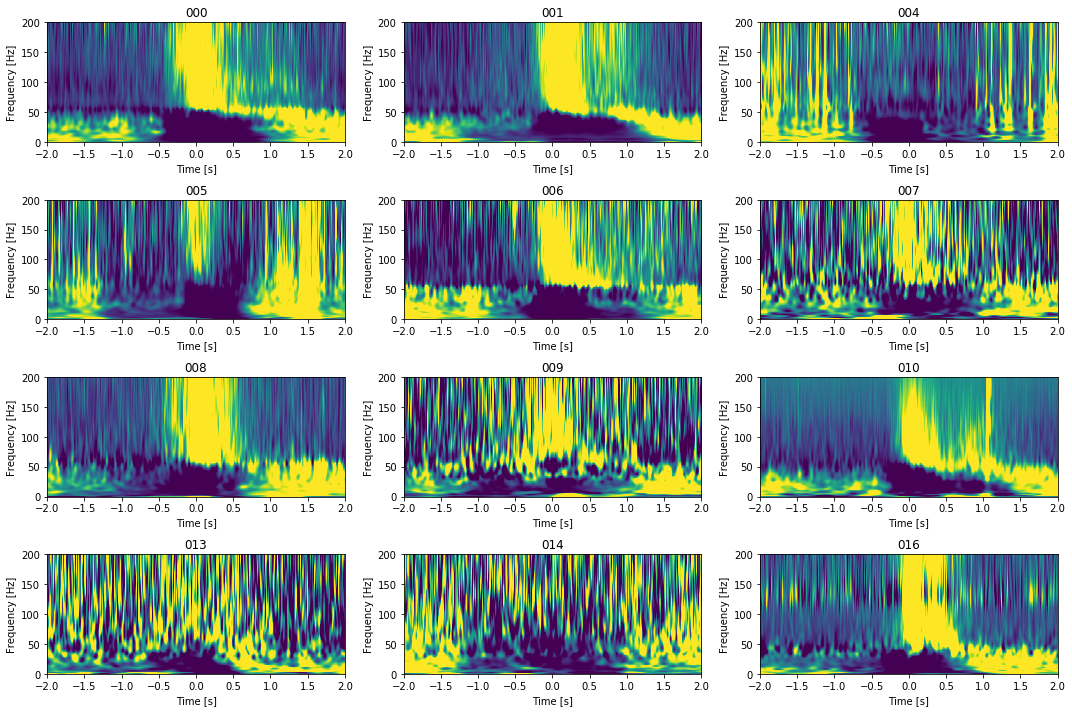

tf_ecog_ips


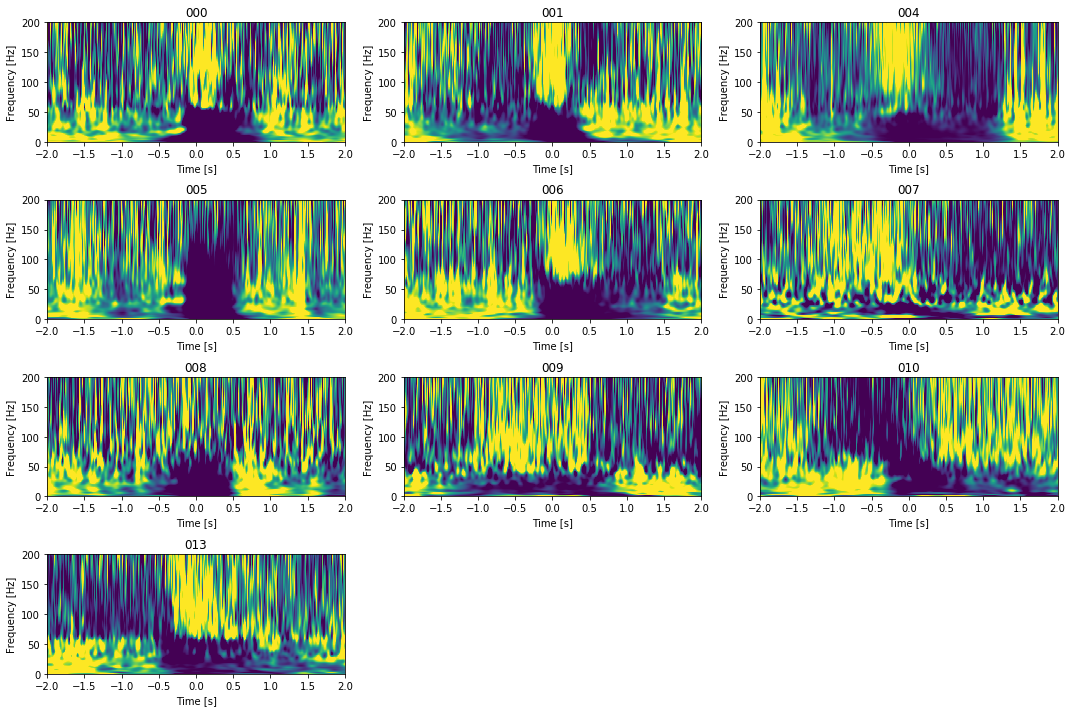

tf_stn_con


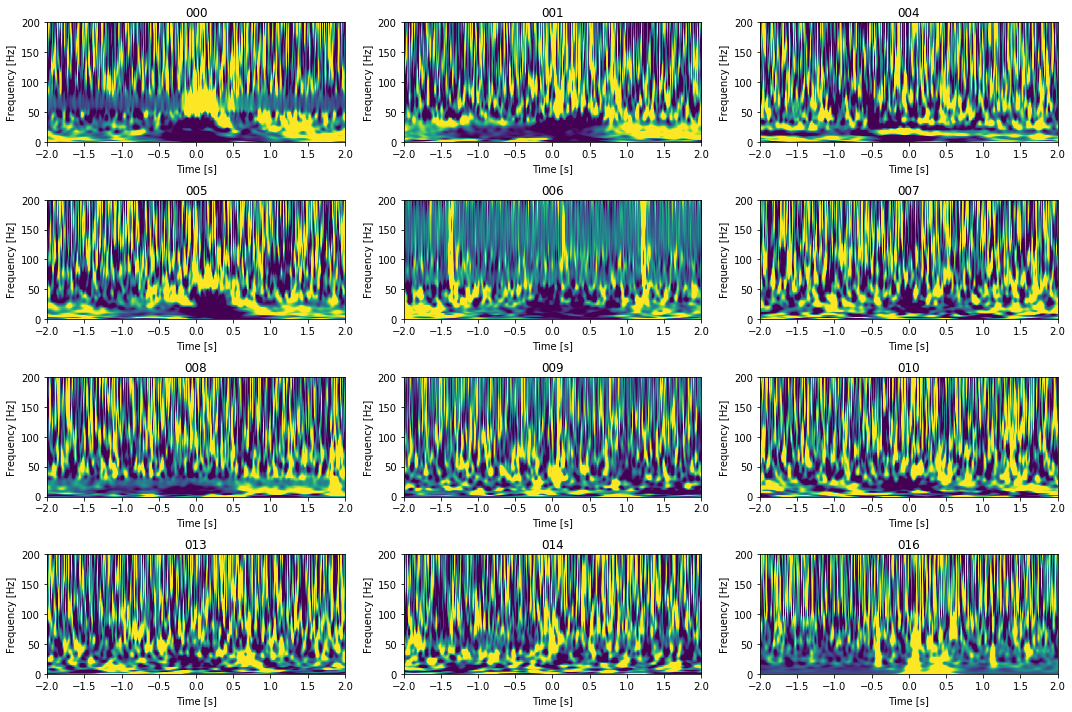

tf_stn_ips


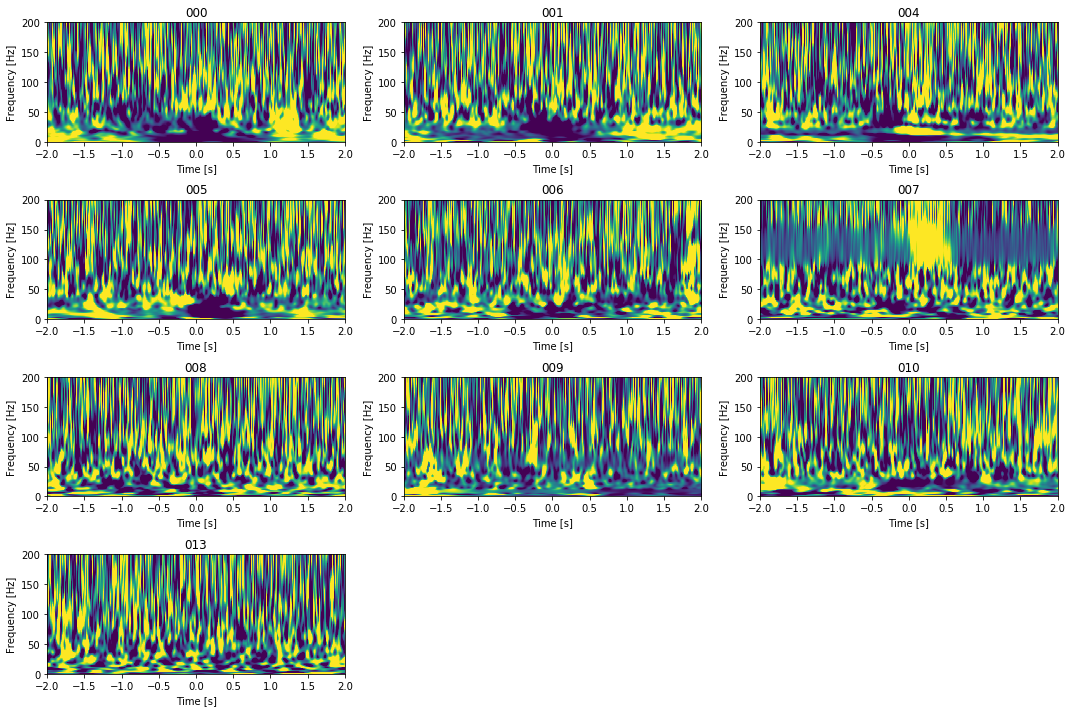

In [16]:
print('tf_ecog_con')
plt.figure(figsize=(15,10))
plot_all_tf(tf_ecog_con)
print('tf_ecog_ips')
plt.figure(figsize=(15,10))
plot_all_tf(tf_ecog_ips)
print('tf_stn_con')
plt.figure(figsize=(15,10))
plot_all_tf(tf_stn_con)
print('tf_stn_ips')
plt.figure(figsize=(15,10))
plot_all_tf(tf_stn_ips)

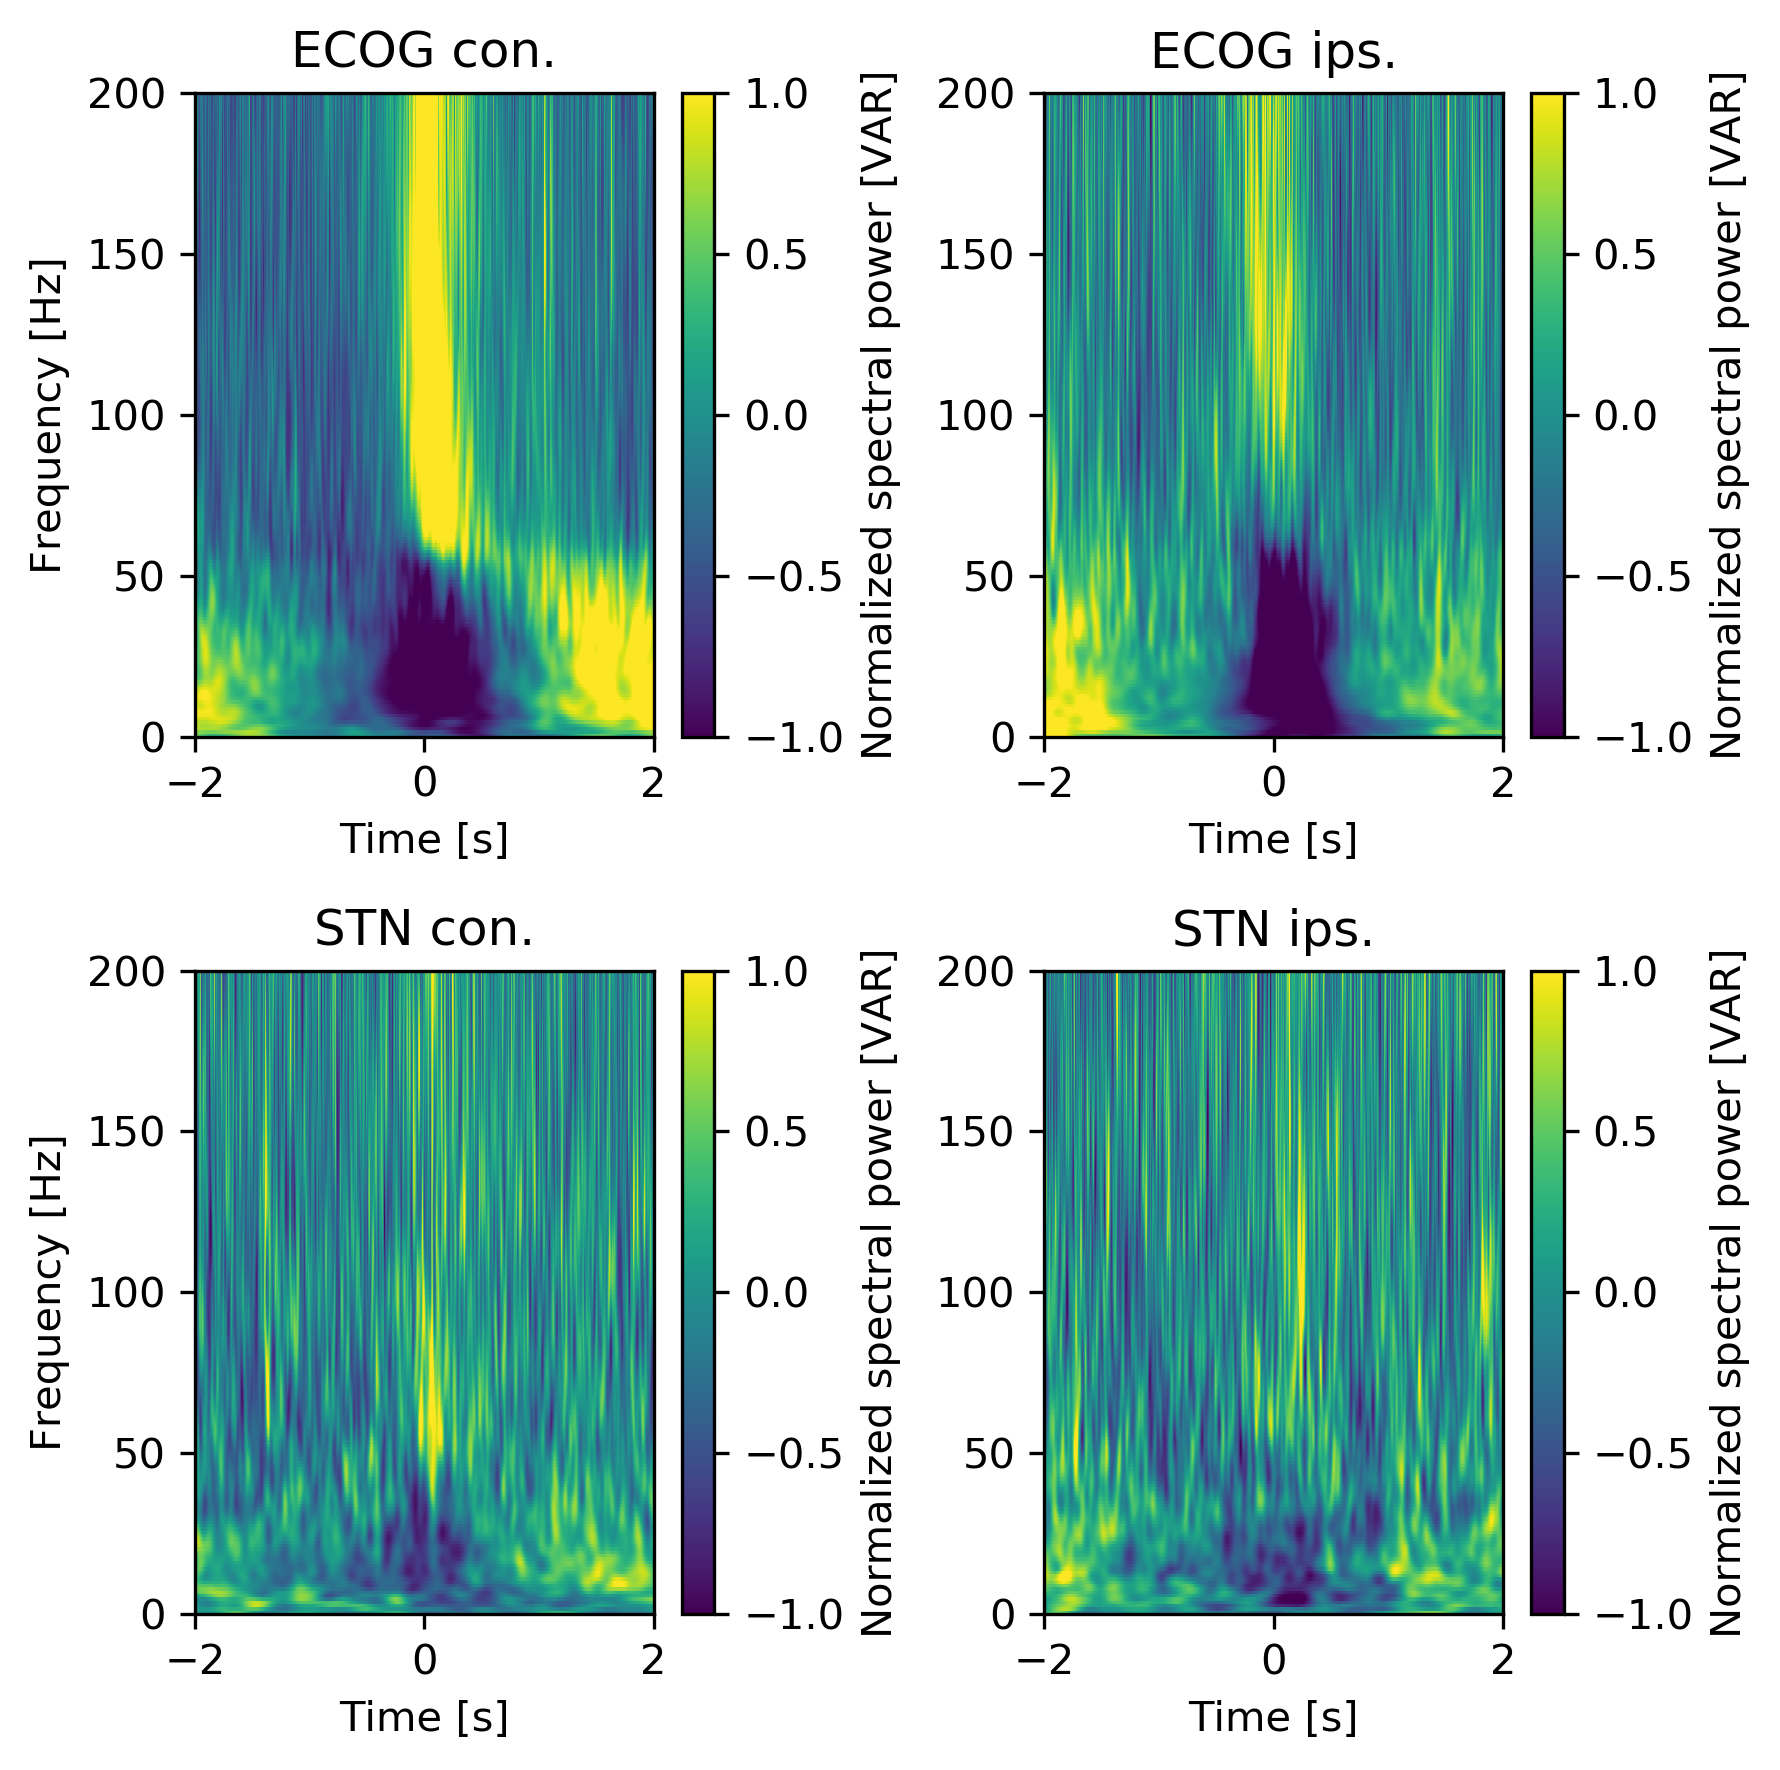

In [19]:
title = ['ECOG con.', 'ECOG ips.', \
        'STN con.', 'STN ips.']
plt.figure(figsize=(6,6), dpi=300)
for idx, dat_ in enumerate([np.mean(tf_ecog_con, axis=0), np.mean(tf_ecog_ips, axis=0), np.mean(tf_stn_con, axis=0), np.mean(tf_stn_ips, axis=0)]):
    plt.subplot(2,2,idx+1)
    plt.imshow(dat_, aspect='auto', extent=[-2,2,200,0])#, cmap='hot')
    cbar = plt.colorbar()
    cbar.set_label('Normalized spectral power [VAR]')
    plt.clim(-1,1)
    plt.gca().invert_yaxis()
    plt.title(title[idx])
    if idx == 0 or idx == 2:
        plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
plt.tight_layout()

### Same plot: but based on the estimated f-bands 

In [36]:
# fs is 10 Hz; estimate the mean +-1 s around the movements
def calc_epochs_f_bands(dat_filtered, y_tr, threshold, epoch_lim):
     
    ind_mov = np.where(np.diff(np.array(y_tr>threshold)*1) == 1)[0]
    low_limit = ind_mov>epoch_lim
    up_limit = ind_mov < y_tr.shape[0]-epoch_lim
    ind_mov = ind_mov[low_limit & up_limit]
    filtered_epoch = np.zeros([ind_mov.shape[0], int(epoch_lim*2), dat_filtered.shape[0]])
    y_arr = np.zeros([ind_mov.shape[0],int(epoch_lim*2)])
    #print(ind_mov)
    for idx, i in enumerate(ind_mov):
        filtered_epoch[idx,:,:] = dat_filtered[:,i-epoch_lim:i+epoch_lim].T
        y_arr[idx,:] = y_tr[i-epoch_lim:i+epoch_lim]

    return filtered_epoch, y_arr

In [93]:
def get_dat(Con = True, ECOG=True):
    dat_filtered = []
    for subject_id_ in subject_id:
        if subject_id_ in subject_exclude:
            continue
        with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
            dict_ch = json.load(fp)

        best_ch, best_acc, dat, mov = \
            get_best(dict_ch, Con=Con, ECOG=ECOG, get_weights=False, get_data=True, measure='R2')
        X_epoch, y_epoch = calc_epochs_f_bands(dat, mov, threshold=0, epoch_lim=20)
        dat_filtered.append(np.mean(X_epoch, axis=0))
    return np.array(dat_filtered)


In [94]:
ECOG_CON_mean_tf = get_dat(True, True)
ECOG_IPS_mean_tf = get_dat(False, True)
STN_CON_mean_tf = get_dat(True, False)
STN_IPS_mean_tf = get_dat(False, False)

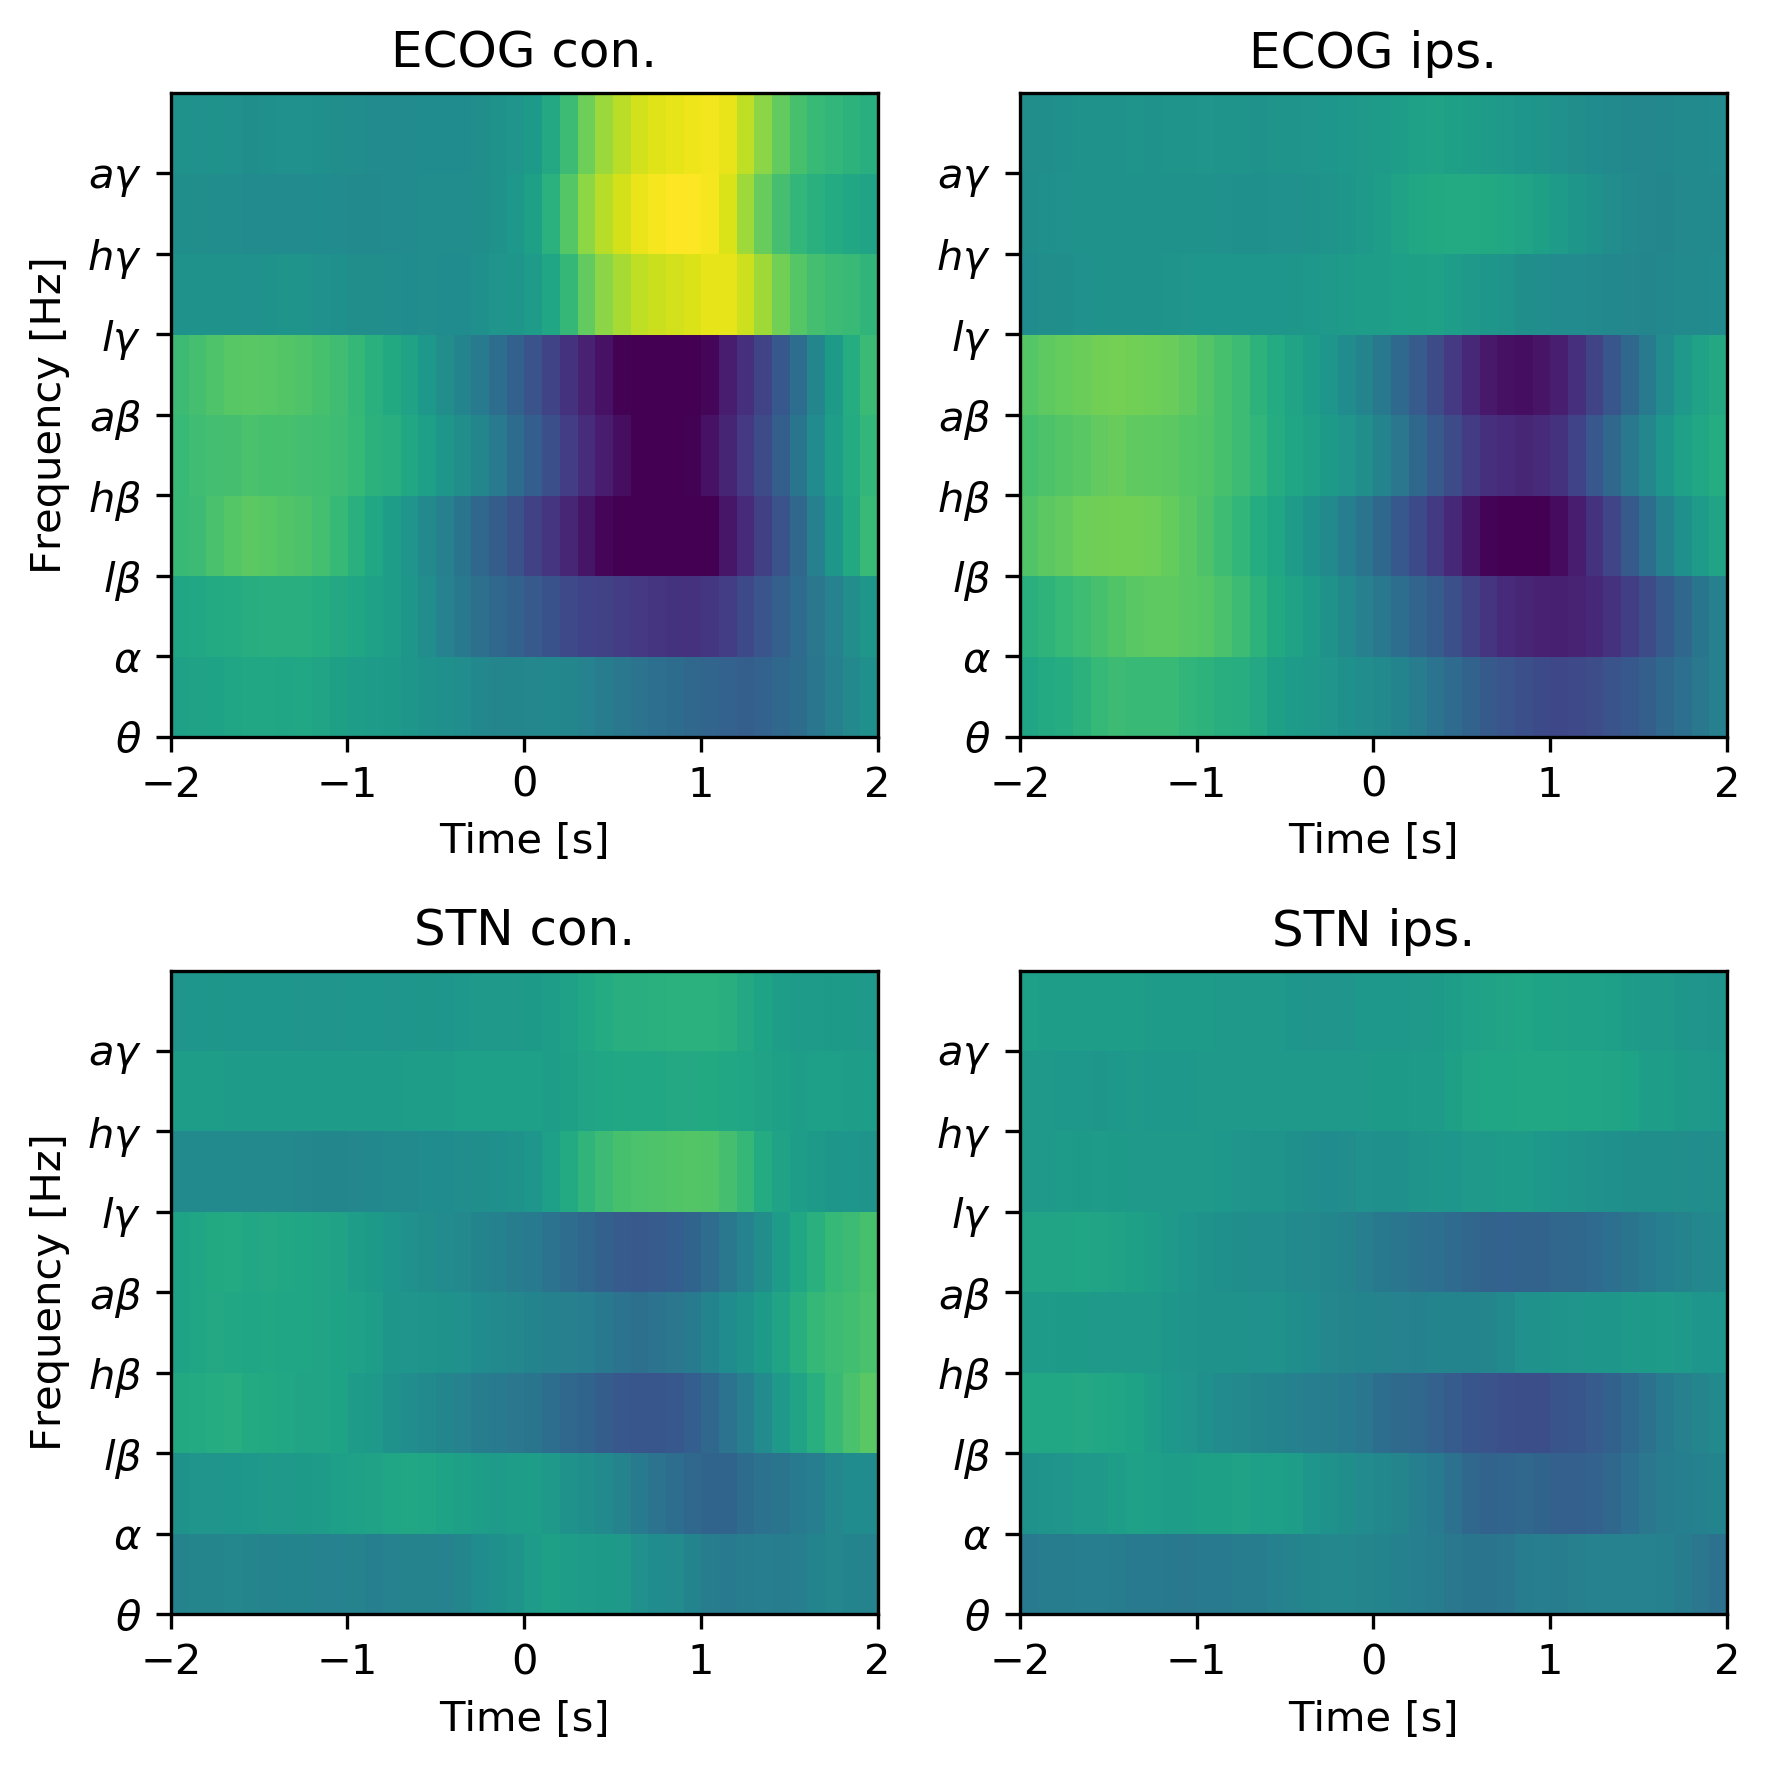

In [95]:
title = ['ECOG con.', 'ECOG ips.', \
        'STN con.', 'STN ips.']
plt.figure(figsize=(6,6), dpi=300)
for idx, dat_ in enumerate([np.mean(ECOG_CON_mean_tf, axis=0), \
        np.mean(ECOG_IPS_mean_tf, axis=0), np.mean(STN_CON_mean_tf,\
        axis=0), np.mean(STN_IPS_mean_tf, axis=0)]):
    plt.subplot(2,2,idx+1)
    plt.imshow(dat_.T, aspect='auto', extent=[-2,2,8,0])#, cmap='hot')
    
    plt.yticks(np.arange(8), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                             r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])
    plt.gca().invert_yaxis()
    plt.clim(0.5,1.4)
    #cbar = plt.colorbar()
    #cbar.set_label('Band power')
    plt.title(title[idx])
    if idx == 0 or idx == 2:
        plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
plt.tight_layout()

In [83]:
def plot_all_patients(dat_):
    for patient_idx in range(dat_.shape[0]): 
        dat_patient = dat_[patient_idx, :, :]
        plt.imshow(dat_patient.T, aspect='auto', extent=[-1,1,8,0])#, cmap='hot')

        plt.yticks(np.arange(8), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                                 r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])
        plt.gca().invert_yaxis()
        #plt.colorbar()
        #plt.clim(-1,1)

        plt.title(patient_idx)
        if idx == 0 or idx == 2:
            plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [s]')
        plt.show()


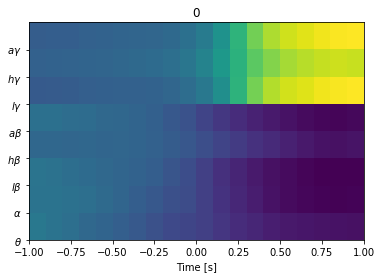

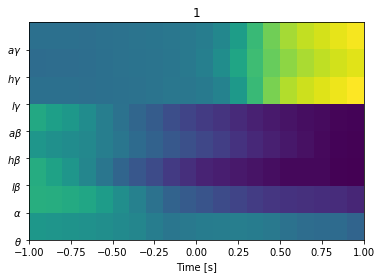

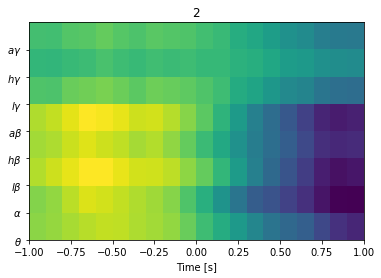

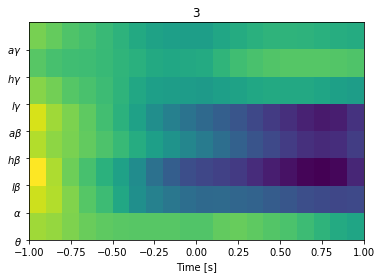

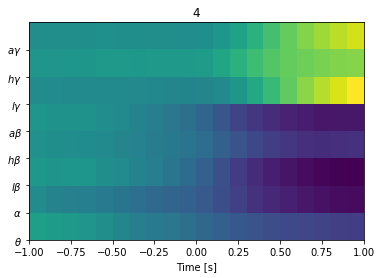

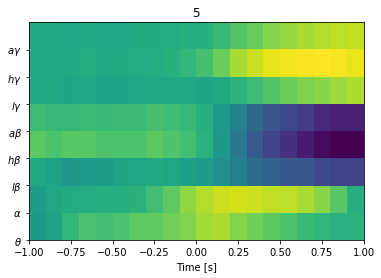

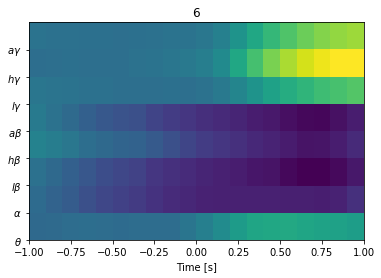

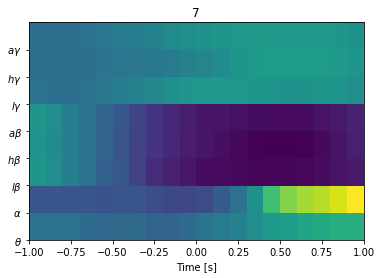

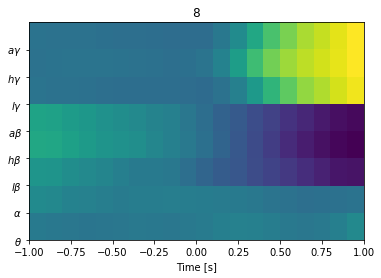

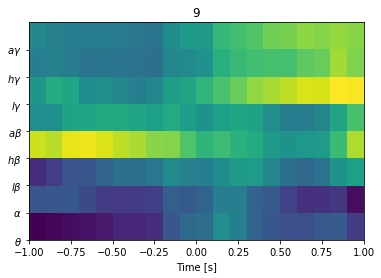

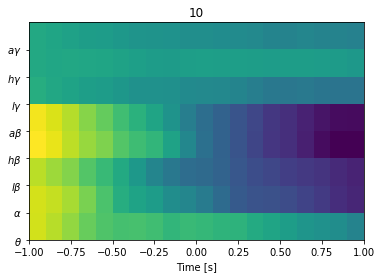

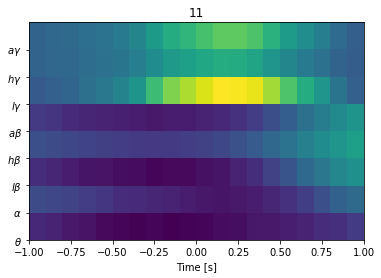

In [84]:
plot_all_patients(ECOG_CON_mean_tf)

In [61]:
ECOG_CON_mean_tf.shape

(12, 20, 8)

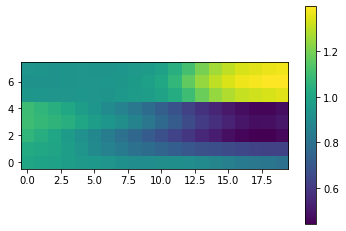

In [80]:
plt.imshow(np.mean(ECOG_CON_mean_tf, axis=0).T)
plt.gca().invert_yaxis()
#plt.clim(-1,2)
plt.colorbar()

In [20]:
subject_id_ = '000'
with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
            dict_ch = json.load(fp)

In [21]:
f_band = 0
time_shift = 0
best_ch, best_acc, dat, mov = \
            get_best(dict_ch, Con=True, ECOG=True, get_weights=False, get_data=True, measure='R2')
X = dat[f_band,time_shift:]

In [22]:
dat.shape

(8, 7570)

In [29]:
X_epoch, y_epoch = calc_epochs_f_bands(dat, mov, 0, 10)

[  29   89  183  324  409  540  722  883  976 1065 1197 1293 1328 1335
 1342 1356 1391 1489 1533 1797 2014 2147 2194 2328 2690 2813 2864 2958
 3093 3227 3356 3409 3634 3770 3821 3909 4070 4110 4160 4301 4542 4715
 4780 4987 5039 5127 5226 5494 5718 5811 5861 5956 5999 6300 6348 6481
 6626 6677 6895 7079 7207 7290 7375]


In [30]:
X_epoch.shape

(63, 20, 8)

In [33]:
np.mean(X_epoch, axis=0).shape

(20, 8)

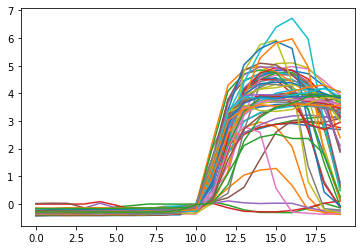

In [32]:
for idx in range(63):
    plt.plot(y_epoch[idx,:])